# Download data and libraries

In [209]:
!pip install -Uqq underthesea

In [210]:
# Install PyDrive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_ids = {
    'word2vec.txt': '1L9DdOOeonW_PpZ7ixuS-WtgXhE7GbOwA'
}

# Download file
for filename, file_id in file_ids.items():
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(filename)
    print(f"Downloaded {filename}")


Downloaded word2vec.txt


# Load pretrained Vietnamese word2vec

In [211]:
import torch
import torchtext.vocab as vocab

word_embedding = vocab.Vectors(name = "word2vec.txt",
                               unk_init = torch.Tensor.normal_)

word_embedding.vectors.shape

torch.Size([6250, 100])

In [212]:
word_embedding.vectors.shape


torch.Size([6250, 100])

In [213]:
# Lưu ma trận word embeddings vào một tệp bằng torch.save()
torch.save(word_embedding, 'word_embeddings.pt')

In [217]:
def get_vector(embeddings, word):
    """ Get embedding vector of the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param word (str)
    @return vector (torch.Tensor)
    """
    assert word in embeddings.stoi, f'*{word}* is not in the vocab!'
    return embeddings.vectors[embeddings.stoi[word]]

def closest_words(embeddings, vector, n=10):
    """ Return n words closest in meaning to the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param vector (torch.Tensor)
    @param n (int)
    @return words (list(tuple(str, float)))
    """
    distances = [(word, torch.dist(vector, get_vector(embeddings, word)).item())
                 for word in embeddings.itos]

    return sorted(distances, key = lambda w: w[1])[:n]


In [218]:
get_vector(word_embedding, "=))")

tensor([-0.0524,  0.2198,  0.0341,  0.0667,  0.0685, -0.3448,  0.2243,  0.5017,
        -0.3036, -0.0485, -0.0718, -0.3842, -0.1026,  0.1339, -0.0350, -0.1742,
         0.0753, -0.2906, -0.0184, -0.3389,  0.0839,  0.0182,  0.0064, -0.2174,
        -0.0853,  0.0883, -0.1861, -0.1856, -0.0943, -0.0368,  0.3119,  0.0282,
         0.1105, -0.1238, -0.0523,  0.3661,  0.1174, -0.1860, -0.1242, -0.4322,
         0.0259, -0.2256, -0.0914,  0.1299,  0.2600,  0.0305, -0.2786, -0.0546,
         0.1725,  0.1289,  0.1099, -0.2924, -0.1014,  0.0305, -0.3265,  0.1585,
         0.1648, -0.1246, -0.3224,  0.0570, -0.0238,  0.1210, -0.0639, -0.0445,
        -0.2806,  0.1889,  0.0547,  0.2162, -0.2127,  0.2026, -0.4158,  0.1253,
         0.2521, -0.1904,  0.3012,  0.1421, -0.0155,  0.1912, -0.3584,  0.1201,
        -0.0571,  0.0419, -0.2927,  0.2666, -0.0123,  0.0570,  0.0271,  0.2038,
         0.2482,  0.0273,  0.2204,  0.1571,  0.0307, -0.0453,  0.3166,  0.1144,
         0.0649, -0.1665,  0.1764, -0.00

In [219]:
word_vector = get_vector(word_embedding, 'vl')
closest_words(word_embedding, word_vector)

[('vl', 0.0),
 ('porto', 0.08383642137050629),
 ('tư', 0.08441320806741714),
 ('🤣🤣🤣', 0.08574710041284561),
 ('đôi', 0.08643840253353119),
 ('ác', 0.08719383180141449),
 ('ngu', 0.08817220479249954),
 ('Khánh', 0.08846817910671234),
 (':)', 0.08860653638839722),
 ('bình', 0.08883475512266159)]

# Vocabulary.py

In [220]:
import torch
from underthesea import word_tokenize


class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert
        text to numbers and vice versa.
    """

    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def id2word(self, word_index):
        """
        @param word_index (int)
        @return word (str)
        """
        return self.id2word[word_index]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @return tokenized_corpus (list(list(str))): list of words
        """
        tokenized_corpus = list()
        for document in corpus:
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        """ Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tokenized_corpus:
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)),
                                             dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        """ Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tensor:
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus


In [222]:
corpus_sample = ["iu nhất thế giới😊",
                 "béo có tội gì chứ😞",
                 "tao hiểu :)) và tao đã chấm dứt ngay😏"]

Vocabulary.tokenize_corpus(corpus_sample)

[['iu', 'nhất', 'thế_giới', '😊'],
 ['béo', 'có', 'tội_gì', 'chứ', '😞'],
 ['tao', 'hiểu', ':))', 'và', 'tao', 'đã', 'chấm_dứt', 'ngay', '😏']]

In [223]:
vocab = Vocabulary()

# create vocabulary from pretrained word2vec
words_list = list(word_embedding.stoi.keys())
for word in words_list:
    vocab.add(word)

In [224]:
vocab.__len__()

6252

In [225]:
# Check if a word is in vocab

vocab.__contains__("'cộng_đồng'")

False

In [226]:
# test the vocabulary
tensor = vocab.corpus_to_tensor(corpus_sample)
corpus = vocab.tensor_to_corpus(tensor)
" ".join(corpus[0])
# >> 'Với cộng_đồng người Bách Việt trước đây , việc <unk> mèo cũng có_thể theo cách_thức như_vậy .'

'iu nhất <unk> 😊'

In [227]:
tensor

[tensor([ 672,  153,    1, 1850]),
 tensor([   1,    4,    1,   35, 1011]),
 tensor([ 187,  179,   49,   41,  187,   60,    1,  473, 3662])]

# Dataset

In [229]:
import pandas as pd
import torch
from torch.utils.data import Dataset


class Dataset(Dataset):
    """ Load dataset from file csv"""

    def __init__(self, vocab, csv_fpath=None, tokenized_fpath=None):
        """
        @param vocab (Vocabulary)
        @param csv_fpath (str)
        @param tokenized_fpath (str)
        """
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]
        df = pd.read_csv(csv_fpath)
        self.sentiments_list = list(df.sentiment)
        self.reviews_list = list(df.vi_review)

        sentiments_type = list(set(self.sentiments_list))
        sentiments_type.sort()

        self.sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments_type)}

        if tokenized_fpath:
            self.tokenized_reviews = torch.load(tokenized_fpath)
        else:
            self.tokenized_reviews = self.vocab.tokenize_corpus(self.reviews_list)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_reviews, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments_list],
                                         dtype=torch.float64)

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        reviews = [e[0] for e in examples]
        reviews = torch.nn.utils.rnn.pad_sequence(reviews,
                                                  batch_first=False,
                                                  padding_value=self.pad_idx)
        reviews_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"reviews": (reviews, reviews_lengths), "sentiments": sentiments}

In [231]:
dataset = Dataset(vocab, "dataset.csv")

In [232]:
torch.save(dataset.tokenized_reviews, "tokenized.pt")

# Split data

In [ ]:
from torch.utils.data import random_split


split_rate = 0.83
full_size = len(dataset)
train_size = (int)(split_rate * full_size)
valid_size = (full_size - train_size)

train_dataset, valid_dataset = random_split(dataset,lengths=[train_size, valid_size])


In [234]:
from torch.utils.data import DataLoader

BATCH_SIZE = 100
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)


In [235]:
import torch

# Save train_dataloader
torch.save(train_dataloader, 'train_dataloader.pth')
# Save valid_dataloader
torch.save(valid_dataloader, 'valid_dataloader.pth')

# Convolutional Neural Network model

In [268]:
import torch
import torch.nn as nn
import torch.nn.functional as F


    
class CNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        
        self.convs = nn.ModuleList()
        current_dim = embedding_dim
        for i in range(n_layers):
            self.convs.append(nn.Conv1d(in_channels=current_dim, 
                                        out_channels=hidden_dim, 
                                        kernel_size=3, 
                                        padding=1)) 
            current_dim = hidden_dim  
            hidden_dim *= 2  
        
        self.fc = nn.Linear(hidden_dim, 1)  
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = embedded.permute(1,2,0) 
        
        conv_input = embedded
        for conv in self.convs:
            conv_output = F.relu(conv(conv_input))
            
            conv_output = F.max_pool1d(conv_output, kernel_size=2)
            conv_input = conv_output
        
        
        conv_output = conv_output.squeeze(-1)
        
        dropped = self.dropout(conv_output)
        return self.fc(dropped)


# Train the model

In [237]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [269]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    @param preds (torch.Tensor): shape = [batch_size]
    @param y (torch.Tensor): shape = [batch_size]
    @return acc (torch.Tensor): shape = [1]
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [271]:
def train(model, dataloader, optimizer, criterion, device):
    """
    @param model (CNN)
    @param dataloader (DataLoader)
    @param optimizer (torch.optim)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in dataloader:

        optimizer.zero_grad()
        reviews, reviews_lengths = batch["reviews"]
        reviews = reviews.to(device)
        predictions = model(reviews, reviews_lengths).squeeze(1)
        sentiments = batch["sentiments"].to(device)
        loss = criterion(predictions, sentiments)
        acc = binary_accuracy(predictions, sentiments)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, epoch_acc / batch_num

In [273]:
def evaluate(model, dataloader, criterion, device):
    """
    @param model (CNN)
    @param dataloader (DataLoader)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:

            reviews, reviews_lengths = batch["reviews"]
            reviews = reviews.to(device)
            predictions = model(reviews, reviews_lengths).squeeze(1)

            sentiments = batch["sentiments"].to(device)
            loss = criterion(predictions, sentiments)
            acc = binary_accuracy(predictions, sentiments)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, epoch_acc / batch_num

In [274]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Tuning CNN : optim, loss function, lr

In [275]:
learning_rate = [0.001, 0.005, 0.01]

criterias = [nn.BCEWithLogitsLoss(),
            nn.BCELoss()]

optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}


In [276]:
bestModelCNN = []

In [277]:
import matplotlib.pyplot as plt

In [278]:
def Tuning_model_CNN(learning_rate, criterias, optimizers, train_dataloader, valid_dataloader, device, num_epochs=5):

  best_valid_loss = float("inf")

  for criteria in criterias:
    for lr in learning_rate:
      for optimizer_name, optimizer_fn in optimizers.items():

        print(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")

        # Initialize model
        INPUT_DIM = len(vocab)
        EMBEDDING_DIM = 100
        HIDDEN_DIM = 256
        N_LAYERS = 2
        DROPOUT = 0.3
        PAD_IDX = vocab["<pad>"]
        UNK_IDX = vocab["<unk>"]


        model = CNN(INPUT_DIM,
                    EMBEDDING_DIM,
                    HIDDEN_DIM,
                    N_LAYERS,
                    DROPOUT,
                    PAD_IDX)
        model.embedding.weight.data.copy_(word_embedding.vectors)
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


        # Define criterion
        criterion = criteria

        # Define optimizer
        optimizer = optimizer_fn(model.parameters(), lr=lr)

        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        # GPU
        model = model.to(device)
        criterion = criterion.to(device)

        for epoch in range(num_epochs):

          start_time = time.time()

          train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
          valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

          train_losses.append(train_loss)
          train_accs.append(train_acc)
          val_losses.append(valid_loss)
          val_accs.append(valid_acc)

          end_time = time.time()

          epoch_mins, epoch_secs = epoch_time(start_time, end_time)

          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), "BestModelCNN.pt")
              bestModelCNN.append(f"criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")


          print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
          print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
          print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")



        # Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")
        plt.legend()

        plt.tight_layout()
        plt.show()




Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.001
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 68.63%
	 Val. Loss: 0.537 |  Val. Acc: 70.55%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.450 | Train Acc: 79.88%
	 Val. Loss: 0.493 |  Val. Acc: 73.82%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.362 | Train Acc: 85.25%
	 Val. Loss: 0.455 |  Val. Acc: 77.27%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.287 | Train Acc: 89.33%
	 Val. Loss: 0.447 |  Val. Acc: 78.45%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.231 | Train Acc: 91.83%
	 Val. Loss: 0.443 |  Val. Acc: 79.91%


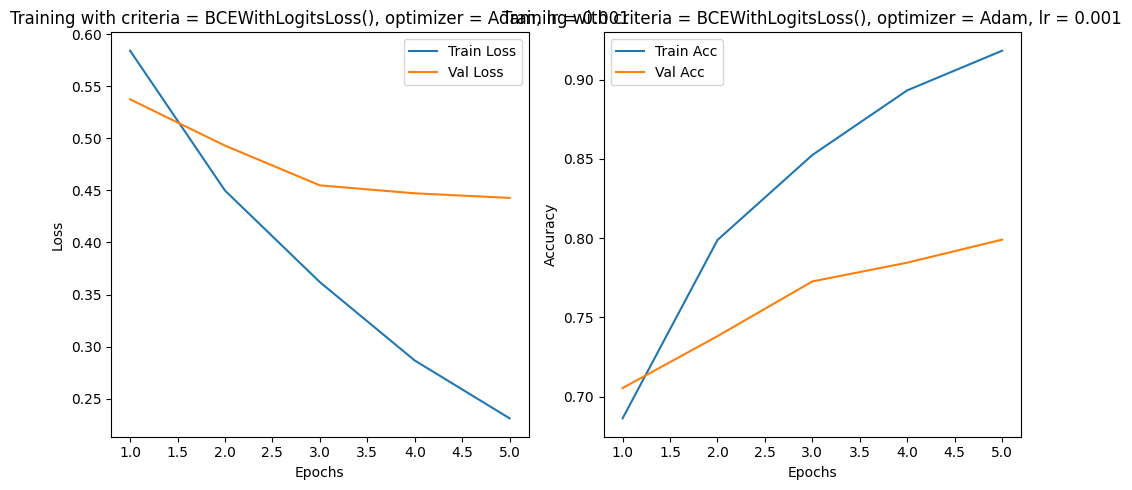

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.001
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.696 | Train Acc: 50.58%
	 Val. Loss: 0.690 |  Val. Acc: 53.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.684 | Train Acc: 55.88%
	 Val. Loss: 0.684 |  Val. Acc: 57.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.680 | Train Acc: 58.56%
	 Val. Loss: 0.681 |  Val. Acc: 58.18%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.675 | Train Acc: 59.87%
	 Val. Loss: 0.677 |  Val. Acc: 58.09%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 61.06%
	 Val. Loss: 0.673 |  Val. Acc: 58.82%


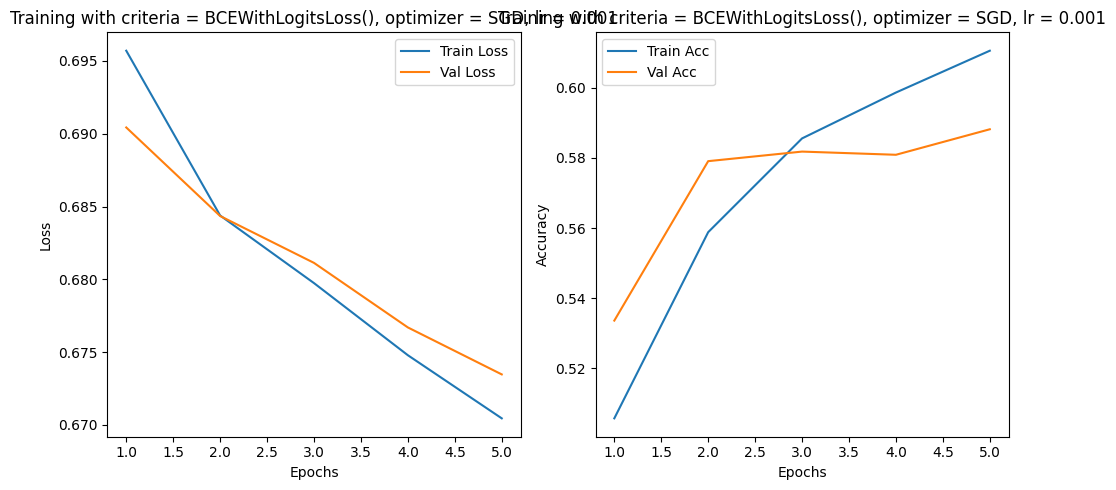

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.001
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.556 | Train Acc: 72.02%
	 Val. Loss: 0.642 |  Val. Acc: 69.73%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.391 | Train Acc: 83.65%
	 Val. Loss: 0.465 |  Val. Acc: 76.36%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.308 | Train Acc: 87.60%
	 Val. Loss: 0.460 |  Val. Acc: 76.27%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.240 | Train Acc: 91.08%
	 Val. Loss: 0.439 |  Val. Acc: 79.09%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.193 | Train Acc: 93.46%
	 Val. Loss: 0.452 |  Val. Acc: 79.55%


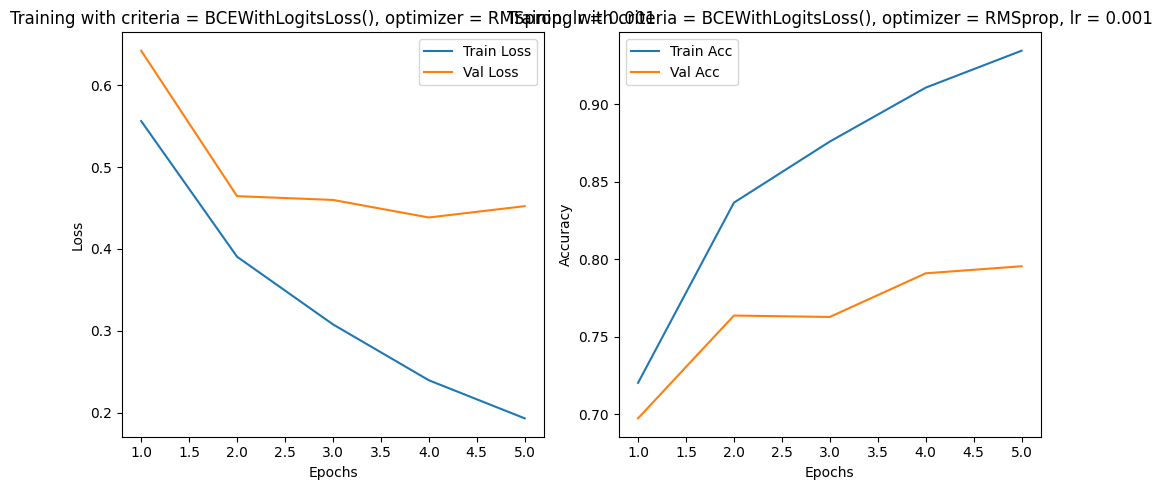

Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.005
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.582 | Train Acc: 69.63%
	 Val. Loss: 0.532 |  Val. Acc: 72.73%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.360 | Train Acc: 84.12%
	 Val. Loss: 0.505 |  Val. Acc: 76.09%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.241 | Train Acc: 89.77%
	 Val. Loss: 0.523 |  Val. Acc: 78.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 93.79%
	 Val. Loss: 0.578 |  Val. Acc: 79.09%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.111 | Train Acc: 95.15%
	 Val. Loss: 0.645 |  Val. Acc: 79.27%


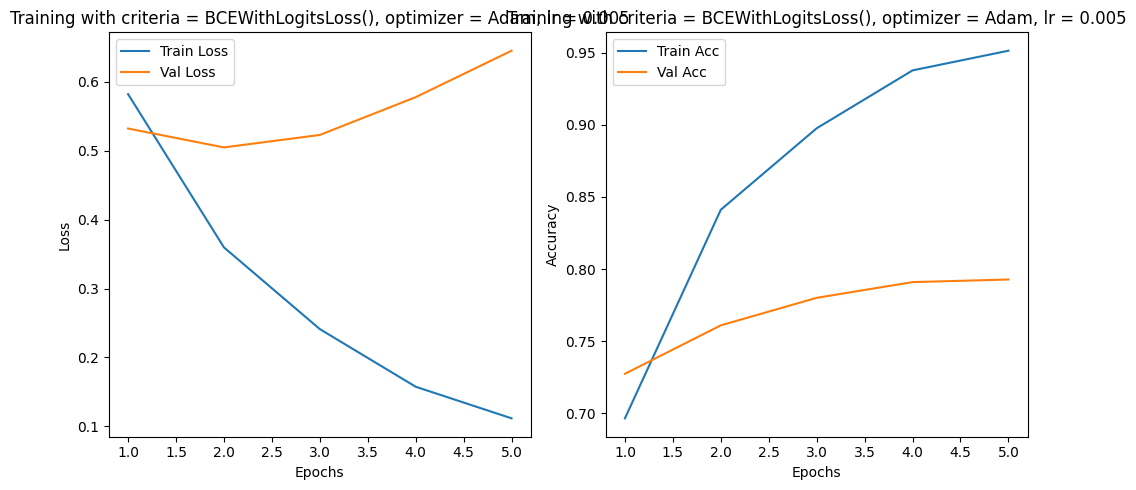

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.005
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.683 | Train Acc: 56.73%
	 Val. Loss: 0.672 |  Val. Acc: 58.64%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 61.94%
	 Val. Loss: 0.659 |  Val. Acc: 61.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.651 | Train Acc: 63.02%
	 Val. Loss: 0.656 |  Val. Acc: 62.64%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.643 | Train Acc: 65.00%
	 Val. Loss: 0.653 |  Val. Acc: 62.27%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.636 | Train Acc: 64.94%
	 Val. Loss: 0.646 |  Val. Acc: 63.00%


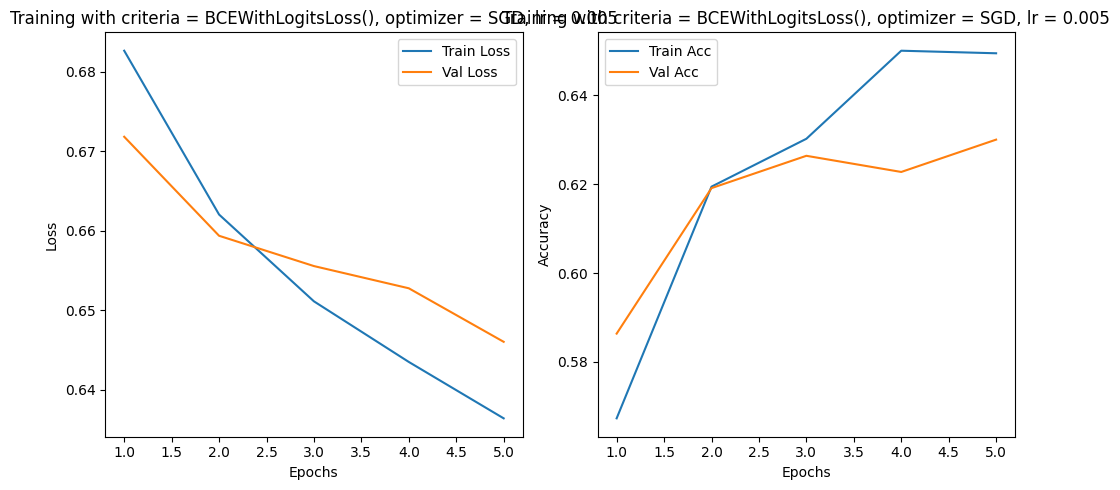

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.005
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.987 | Train Acc: 70.50%
	 Val. Loss: 0.520 |  Val. Acc: 75.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.338 | Train Acc: 85.21%
	 Val. Loss: 0.571 |  Val. Acc: 76.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Acc: 89.83%
	 Val. Loss: 0.819 |  Val. Acc: 70.18%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.165 | Train Acc: 93.13%
	 Val. Loss: 0.527 |  Val. Acc: 80.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 95.12%
	 Val. Loss: 0.767 |  Val. Acc: 73.64%


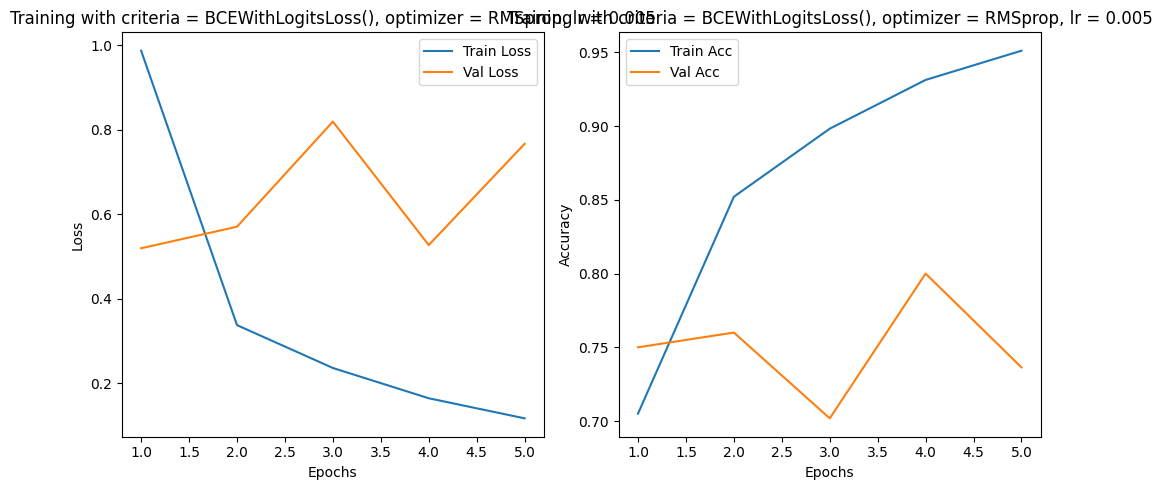

Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.01
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.540 | Train Acc: 72.92%
	 Val. Loss: 0.483 |  Val. Acc: 77.27%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.314 | Train Acc: 86.17%
	 Val. Loss: 0.577 |  Val. Acc: 77.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.198 | Train Acc: 91.33%
	 Val. Loss: 0.588 |  Val. Acc: 80.18%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.146 | Train Acc: 93.75%
	 Val. Loss: 0.668 |  Val. Acc: 80.18%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.131 | Train Acc: 94.37%
	 Val. Loss: 0.831 |  Val. Acc: 80.36%


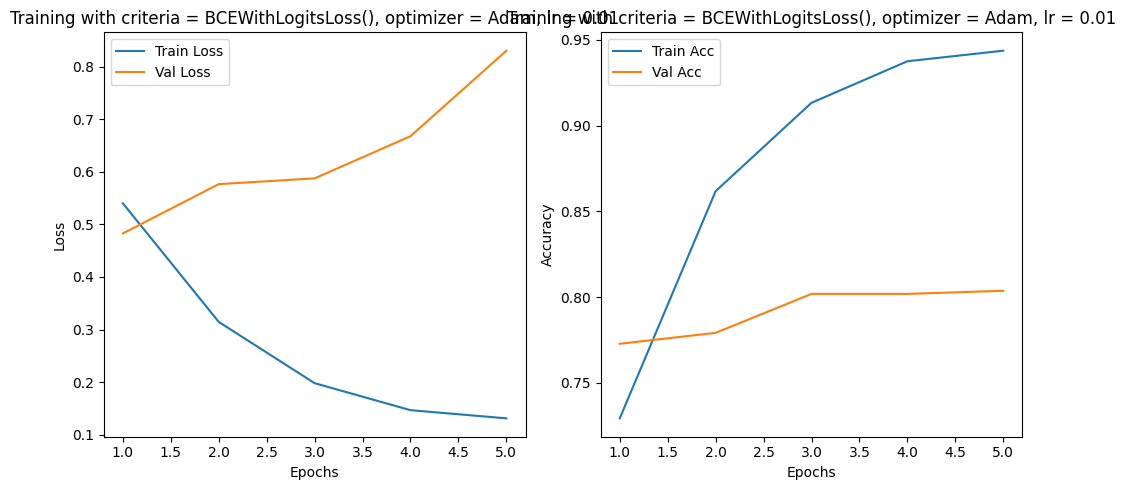

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.01
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.672 | Train Acc: 59.02%
	 Val. Loss: 0.660 |  Val. Acc: 64.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.647 | Train Acc: 63.71%
	 Val. Loss: 0.669 |  Val. Acc: 58.64%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.634 | Train Acc: 64.50%
	 Val. Loss: 0.651 |  Val. Acc: 61.64%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.623 | Train Acc: 66.06%
	 Val. Loss: 0.633 |  Val. Acc: 65.55%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.612 | Train Acc: 67.63%
	 Val. Loss: 0.625 |  Val. Acc: 65.91%


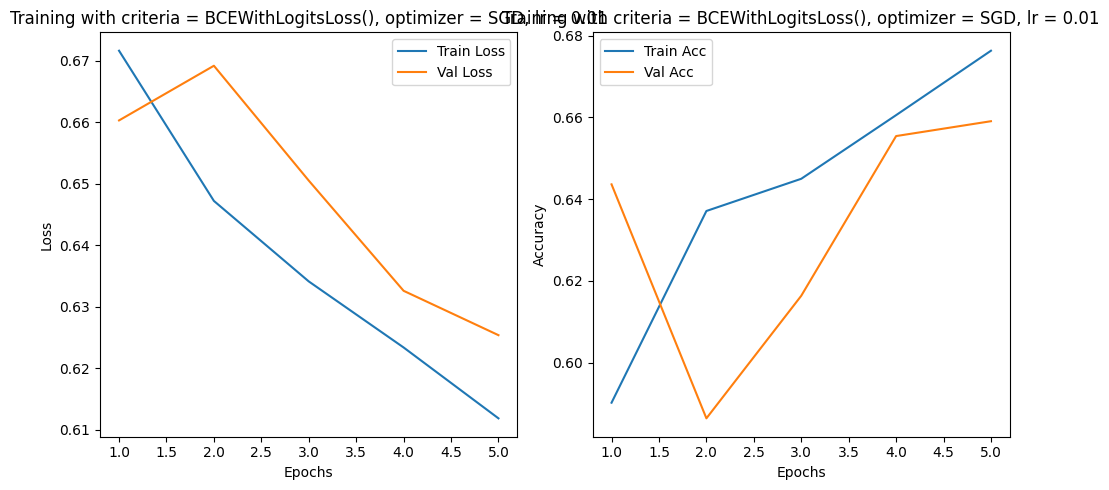

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.01
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.715 | Train Acc: 68.19%
	 Val. Loss: 0.597 |  Val. Acc: 76.45%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.301 | Train Acc: 87.02%
	 Val. Loss: 0.548 |  Val. Acc: 76.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.189 | Train Acc: 92.13%
	 Val. Loss: 0.581 |  Val. Acc: 76.27%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 94.06%
	 Val. Loss: 0.592 |  Val. Acc: 79.27%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 94.79%
	 Val. Loss: 0.683 |  Val. Acc: 79.36%


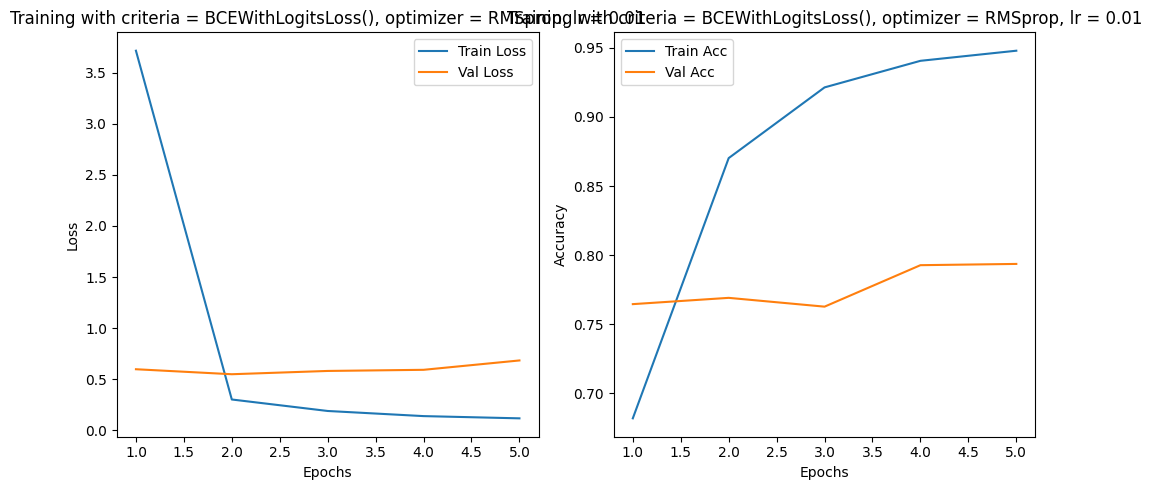

Training with criteria = BCELoss(), optimizer = Adam, lr = 0.001


RuntimeError: Found dtype Double but expected Float

In [279]:
Tuning_model_CNN(learning_rate, criterias, optimizers, train_dataloader, valid_dataloader, device, num_epochs=5)

Training with HIDDEN_DIM=128, N_LAYERS=2, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.605 | Train Acc: 67.90%
	Val. Loss: 0.554 | Val. Acc: 71.27%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.482 | Train Acc: 78.37%
	Val. Loss: 0.498 | Val. Acc: 75.18%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.391 | Train Acc: 83.73%
	Val. Loss: 0.470 | Val. Acc: 75.91%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.324 | Train Acc: 87.50%
	Val. Loss: 0.444 | Val. Acc: 79.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.265 | Train Acc: 90.96%
	Val. Loss: 0.432 | Val. Acc: 80.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.221 | Train Acc: 92.83%
	Val. Loss: 0.436 | Val. Acc: 79.82%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.184 | Train Acc: 94.25%
	Val. Loss: 0.427 | Val. Acc: 81.27%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.161 | Train Acc: 95.06%
	Val. Loss: 0.445 | Val. Acc: 81.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.140 | Train Acc: 95.58%
	Val. Loss: 0.455 | Val. Acc:

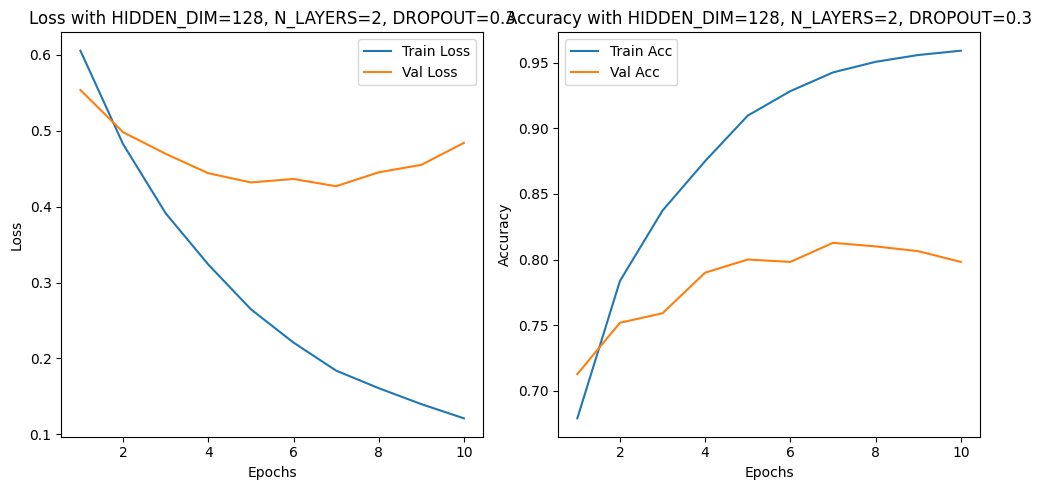

Training with HIDDEN_DIM=128, N_LAYERS=2, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.600 | Train Acc: 67.58%
	Val. Loss: 0.552 | Val. Acc: 72.64%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.477 | Train Acc: 78.63%
	Val. Loss: 0.487 | Val. Acc: 76.18%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.393 | Train Acc: 83.29%
	Val. Loss: 0.451 | Val. Acc: 76.91%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.327 | Train Acc: 87.04%
	Val. Loss: 0.438 | Val. Acc: 78.64%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.268 | Train Acc: 90.15%
	Val. Loss: 0.426 | Val. Acc: 79.64%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.227 | Train Acc: 92.23%
	Val. Loss: 0.430 | Val. Acc: 79.91%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.191 | Train Acc: 93.77%
	Val. Loss: 0.430 | Val. Acc: 80.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.162 | Train Acc: 94.79%
	Val. Loss: 0.444 | Val. Acc: 79.55%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.137 | Train Acc: 95.79%
	Val. Loss: 0.443 | Val. Acc:

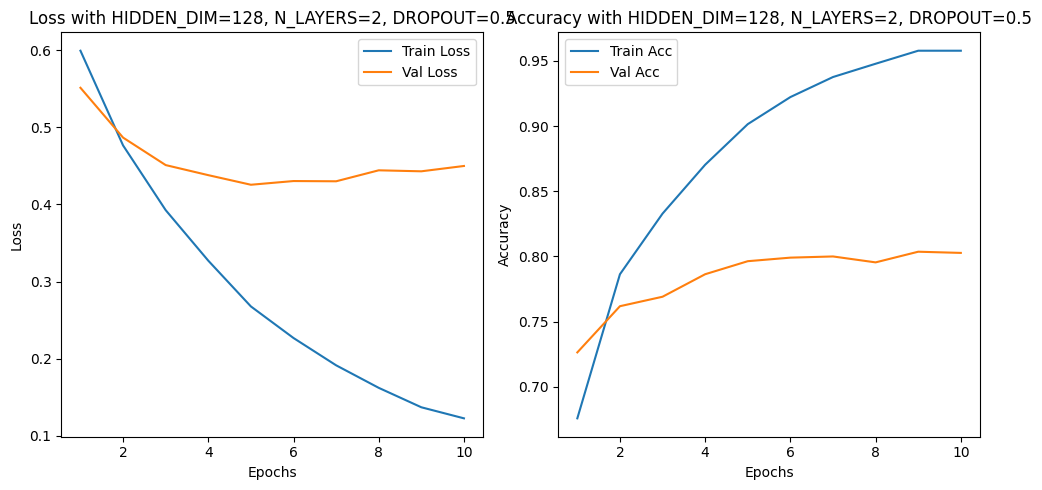

Training with HIDDEN_DIM=128, N_LAYERS=3, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.600 | Train Acc: 67.69%
	Val. Loss: 0.545 | Val. Acc: 72.64%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.475 | Train Acc: 78.50%
	Val. Loss: 0.493 | Val. Acc: 75.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.395 | Train Acc: 83.85%
	Val. Loss: 0.466 | Val. Acc: 76.09%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.324 | Train Acc: 87.21%
	Val. Loss: 0.448 | Val. Acc: 78.09%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.273 | Train Acc: 89.87%
	Val. Loss: 0.447 | Val. Acc: 77.27%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.227 | Train Acc: 92.54%
	Val. Loss: 0.437 | Val. Acc: 79.09%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.189 | Train Acc: 94.17%
	Val. Loss: 0.437 | Val. Acc: 79.55%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.162 | Train Acc: 94.90%
	Val. Loss: 0.441 | Val. Acc: 80.64%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.140 | Train Acc: 95.65%
	Val. Loss: 0.452 | Val. Acc:

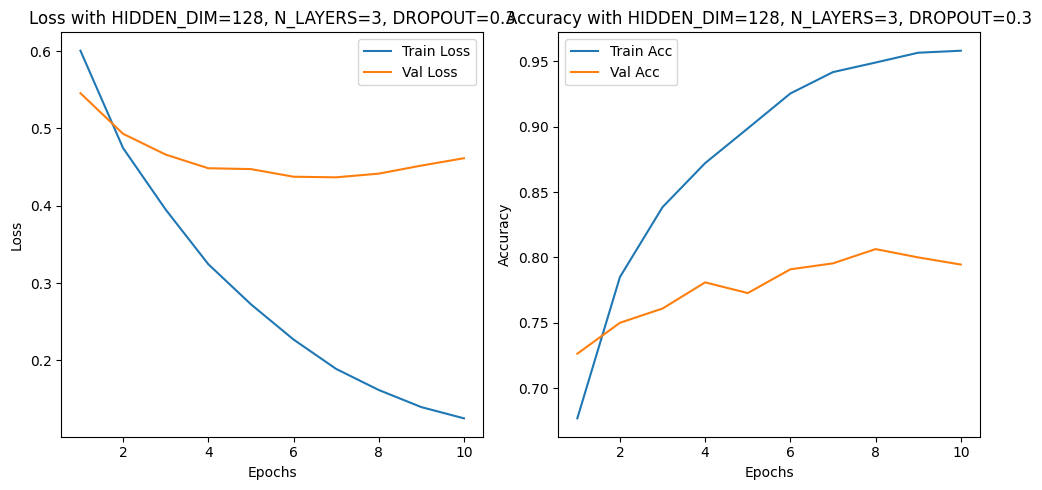

Training with HIDDEN_DIM=128, N_LAYERS=3, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Acc: 68.38%
	Val. Loss: 0.544 | Val. Acc: 72.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.472 | Train Acc: 78.44%
	Val. Loss: 0.506 | Val. Acc: 74.36%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.391 | Train Acc: 83.50%
	Val. Loss: 0.462 | Val. Acc: 76.64%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.327 | Train Acc: 87.19%
	Val. Loss: 0.450 | Val. Acc: 78.18%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.272 | Train Acc: 90.12%
	Val. Loss: 0.443 | Val. Acc: 78.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.229 | Train Acc: 92.12%
	Val. Loss: 0.440 | Val. Acc: 79.36%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.187 | Train Acc: 94.00%
	Val. Loss: 0.425 | Val. Acc: 80.73%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.98%
	Val. Loss: 0.434 | Val. Acc: 80.18%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 95.54%
	Val. Loss: 0.433 | Val. Acc:

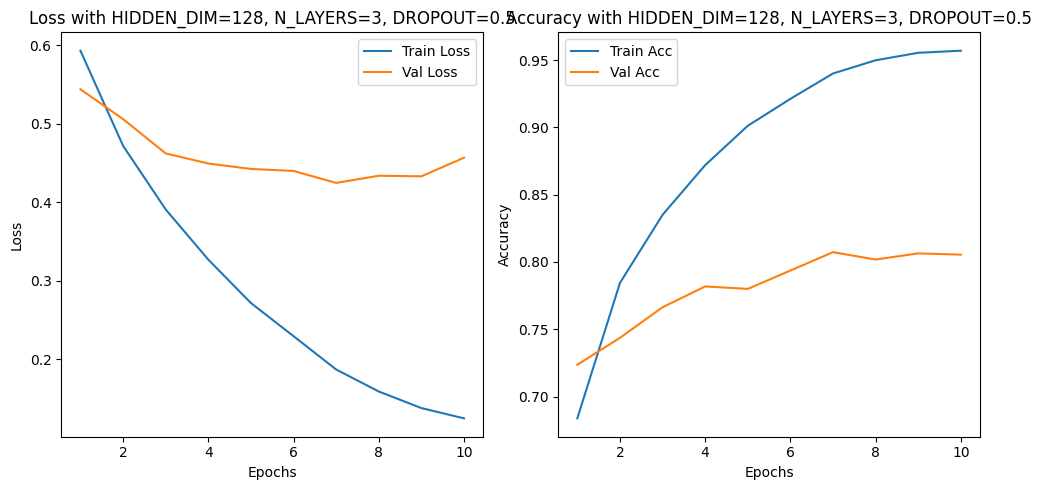

Training with HIDDEN_DIM=256, N_LAYERS=2, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 69.60%
	Val. Loss: 0.530 | Val. Acc: 73.18%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.448 | Train Acc: 79.90%
	Val. Loss: 0.511 | Val. Acc: 74.64%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.365 | Train Acc: 84.92%
	Val. Loss: 0.463 | Val. Acc: 77.09%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.296 | Train Acc: 88.37%
	Val. Loss: 0.457 | Val. Acc: 77.18%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Acc: 91.94%
	Val. Loss: 0.441 | Val. Acc: 78.55%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.191 | Train Acc: 93.46%
	Val. Loss: 0.470 | Val. Acc: 79.36%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.52%
	Val. Loss: 0.485 | Val. Acc: 80.55%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.136 | Train Acc: 95.56%
	Val. Loss: 0.490 | Val. Acc: 80.27%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.15%
	Val. Loss: 0.498 | Val. Acc:

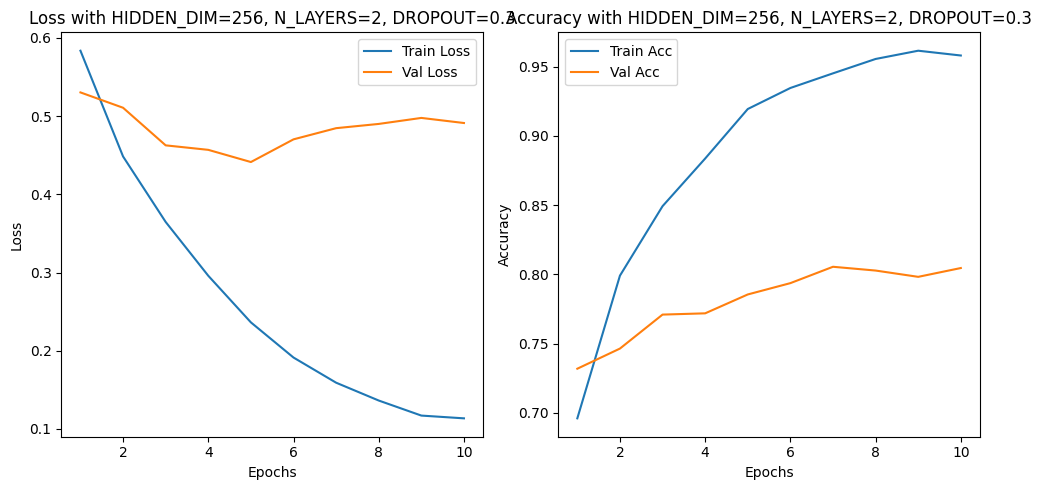

Training with HIDDEN_DIM=256, N_LAYERS=2, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.597 | Train Acc: 68.04%
	Val. Loss: 0.533 | Val. Acc: 72.64%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.463 | Train Acc: 78.90%
	Val. Loss: 0.481 | Val. Acc: 75.09%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.371 | Train Acc: 84.85%
	Val. Loss: 0.449 | Val. Acc: 76.73%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.299 | Train Acc: 89.13%
	Val. Loss: 0.439 | Val. Acc: 78.91%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.240 | Train Acc: 91.94%
	Val. Loss: 0.439 | Val. Acc: 78.64%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.201 | Train Acc: 93.40%
	Val. Loss: 0.429 | Val. Acc: 80.09%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.164 | Train Acc: 94.62%
	Val. Loss: 0.436 | Val. Acc: 80.27%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.137 | Train Acc: 95.56%
	Val. Loss: 0.443 | Val. Acc: 80.45%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.123 | Train Acc: 95.77%
	Val. Loss: 0.454 | Val. Acc:

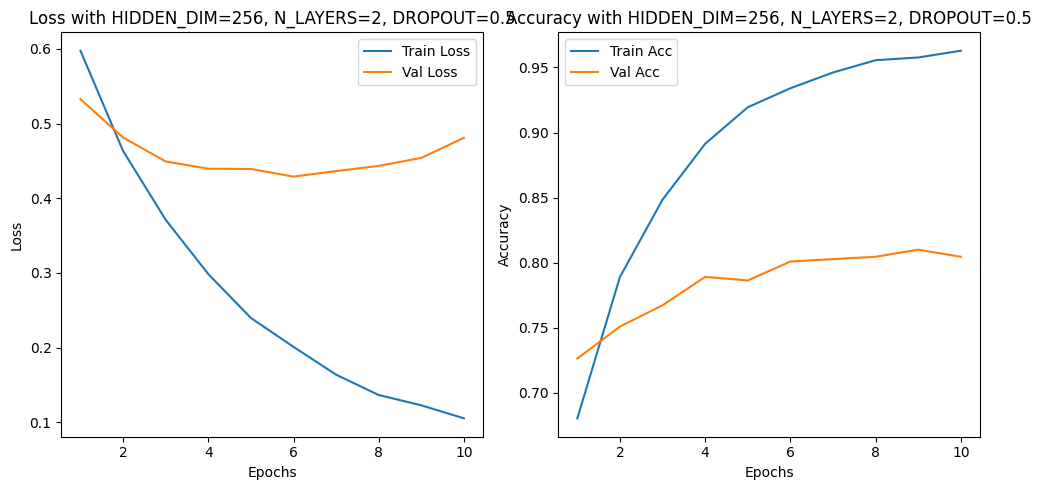

Training with HIDDEN_DIM=256, N_LAYERS=3, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.582 | Train Acc: 69.71%
	Val. Loss: 0.530 | Val. Acc: 73.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.451 | Train Acc: 80.35%
	Val. Loss: 0.500 | Val. Acc: 74.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.358 | Train Acc: 85.62%
	Val. Loss: 0.468 | Val. Acc: 78.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.290 | Train Acc: 89.21%
	Val. Loss: 0.451 | Val. Acc: 77.73%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Acc: 91.62%
	Val. Loss: 0.447 | Val. Acc: 79.55%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.189 | Train Acc: 93.77%
	Val. Loss: 0.459 | Val. Acc: 79.82%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.156 | Train Acc: 94.73%
	Val. Loss: 0.472 | Val. Acc: 80.18%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.130 | Train Acc: 95.71%
	Val. Loss: 0.505 | Val. Acc: 79.82%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.116 | Train Acc: 95.85%
	Val. Loss: 0.519 | Val. Acc:

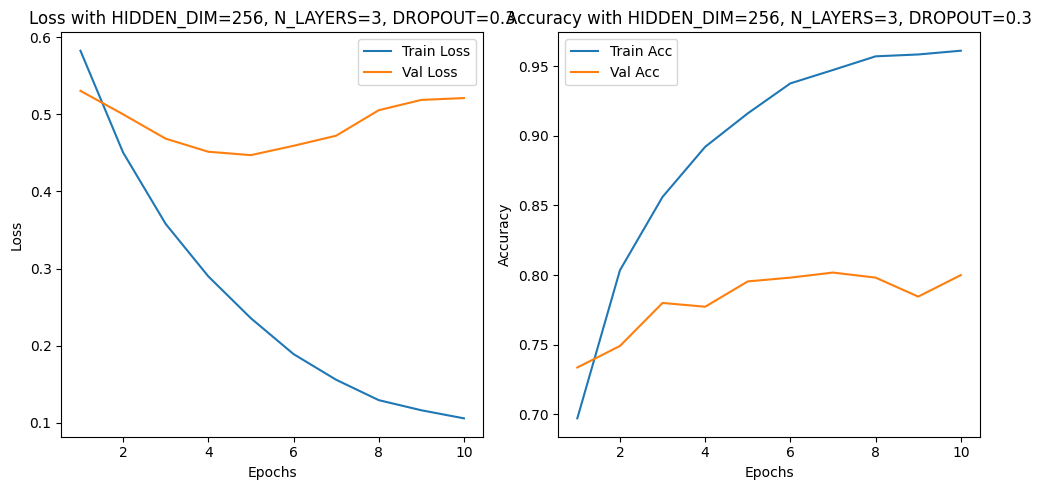

Training with HIDDEN_DIM=256, N_LAYERS=3, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.591 | Train Acc: 68.52%
	Val. Loss: 0.551 | Val. Acc: 71.18%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.452 | Train Acc: 79.83%
	Val. Loss: 0.494 | Val. Acc: 76.27%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.362 | Train Acc: 85.48%
	Val. Loss: 0.494 | Val. Acc: 75.73%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.291 | Train Acc: 89.19%
	Val. Loss: 0.469 | Val. Acc: 77.64%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.231 | Train Acc: 92.35%
	Val. Loss: 0.456 | Val. Acc: 79.36%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.182 | Train Acc: 94.33%
	Val. Loss: 0.460 | Val. Acc: 79.45%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.153 | Train Acc: 94.88%
	Val. Loss: 0.480 | Val. Acc: 79.64%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 95.25%
	Val. Loss: 0.488 | Val. Acc: 79.73%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.115 | Train Acc: 96.13%
	Val. Loss: 0.525 | Val. Acc:

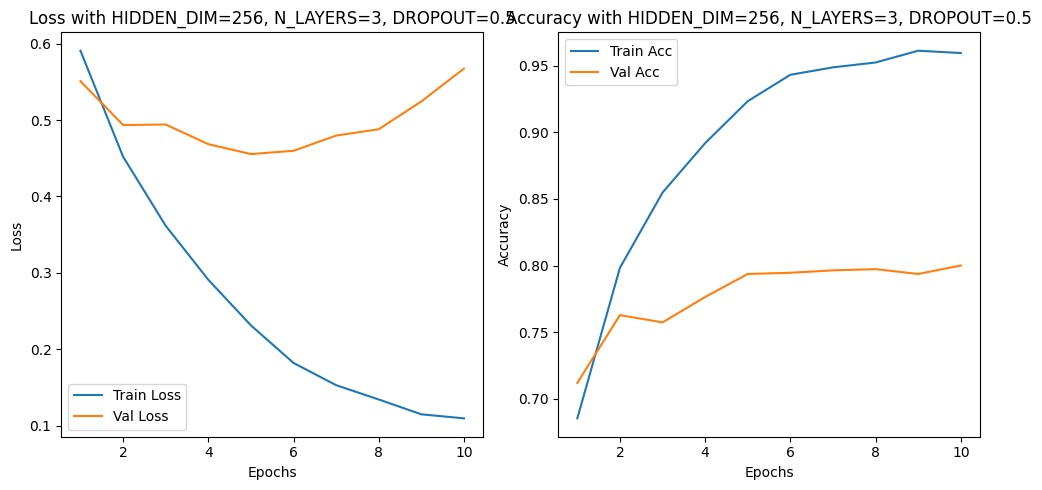

In [280]:
import matplotlib.pyplot as plt


def train_model(HIDDEN_DIMs, N_LAYERSs, DROPOUTs, train_dataloader, valid_dataloader, num_epochs=10):
    best_valid_loss = float("inf")

    for HIDDEN_DIM in HIDDEN_DIMs:
        for N_LAYERS in N_LAYERSs:
            for DROPOUT in DROPOUTs:
                print(f"Training with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")

                # Initialize model
                INPUT_DIM = len(vocab)
                EMBEDDING_DIM = 100
                HIDDEN_DIM = HIDDEN_DIM
                N_LAYERS = N_LAYERS
                DROPOUT = DROPOUT
                PAD_IDX = vocab["<pad>"]
                UNK_IDX = vocab["<unk>"]


                model = CNN(INPUT_DIM,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            N_LAYERS,
                            DROPOUT,
                            PAD_IDX)
                model.embedding.weight.data.copy_(word_embedding.vectors)
                model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
                model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


                optimizer = optim.Adam(model.parameters())
                criterion = nn.BCEWithLogitsLoss()

                train_losses = []
                train_accs = []
                val_losses = []
                val_accs = []

                model = model.to(device)
                criterion = criterion.to(device)

                for epoch in range(num_epochs):
                    start_time = time.time()

                    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
                    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

                    train_losses.append(train_loss)
                    train_accs.append(train_acc)
                    val_losses.append(valid_loss)
                    val_accs.append(valid_acc)

                    end_time = time.time()
                    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        torch.save(model.state_dict(), "best_model_cnn.pt")

                    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
                    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
                    print(f"\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%")

                # Plot
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
                plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title(f"Loss with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
                plt.plot(range(1, num_epochs + 1), val_accs, label='Val Acc')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title(f"Accuracy with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")
                plt.legend()

                plt.tight_layout()
                plt.show()

# Sử dụng hàm train_model với các giá trị hyperparameters
HIDDEN_DIMs = [128, 256]
N_LAYERSs = [2, 3]
DROPOUTs = [0.3, 0.5]

train_model(HIDDEN_DIMs, N_LAYERSs, DROPOUTs, train_dataloader, valid_dataloader, num_epochs=10)

# Final CNN model

- hidden-dim = 128
- n-layers = 2
- dropout = 0.5
- optim = Adam
- loss Function = BCELogistsloss()
- learning-rate = 0.001

In [281]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

model = CNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            N_LAYERS,
            DROPOUT,
            PAD_IDX)
model.embedding.weight.data.copy_(word_embedding.vectors)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [282]:
model.to(device)

CNN(
  (embedding): Embedding(6252, 100, padding_idx=0)
  (conv): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [283]:
# Khởi tạo optimizer và hàm loss
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss().to(device)

In [284]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_valid_loss = float("inf")

for epoch in range(15):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(valid_loss)
  val_accs.append(valid_acc)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), "Best_model_CNN.pt")

  print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.596 | Train Acc: 67.85%
	 Val. Loss: 0.545 |  Val. Acc: 71.91%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.475 | Train Acc: 77.90%
	 Val. Loss: 0.507 |  Val. Acc: 74.36%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.394 | Train Acc: 83.50%
	 Val. Loss: 0.480 |  Val. Acc: 75.82%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.331 | Train Acc: 86.67%
	 Val. Loss: 0.459 |  Val. Acc: 77.45%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.274 | Train Acc: 90.12%
	 Val. Loss: 0.453 |  Val. Acc: 78.91%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.229 | Train Acc: 92.35%
	 Val. Loss: 0.440 |  Val. Acc: 79.73%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.191 | Train Acc: 93.96%
	 Val. Loss: 0.471 |  Val. Acc: 79.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.166 | Train Acc: 94.85%
	 Val. Loss: 0.457 |  Val. Acc: 79.09%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.143 | Train Acc: 95.10%
	 Val. Loss: 0.459 |  Val. Acc: 79.64%
Epoch: 10 | Epoch Time: 0m 0

# 9. Test the model

In [293]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from underthesea import word_tokenize

def predict_sentiment(model, sentence, vocab, device):
    model.eval()
    # Tokenize câu văn bản
    tokenized_sentence = [word.replace(" ", "_") for word in word_tokenize(sentence)]

    # Chuyển đổi câu văn bản thành tensor theo từ điển vocab
    indexed = [vocab[word] for word in tokenized_sentence]
    # indexed_padded = indexed[:3] + [0] * (3 - len(indexed))
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).unsqueeze(1).to(device)

    # Truyền qua mạng CNN
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor, torch.LongTensor(length).to(device)))

    return prediction.item()

In [294]:
dataset.sentiment2id

{'negative': 0, 'positive': 1}

In [302]:
df = pd.read_csv("test.csv")
df = df[df['vi_review'].apply(lambda x: len(x.split()) >= 4)]

In [299]:
def pred(text):
    # Thực hiện dự đoán sentiment cho câu text
    prediction = predict_sentiment(model, text, vocab, device)
    # Trả về nhãn "positive" nếu dự đoán lớn hơn hoặc bằng 0.5, ngược lại trả về "negative"
    return "positive" if prediction >= 0.5 else "negative"

In [304]:
df["pred"] = df["vi_review"].apply(pred)

In [306]:
pre = df[df["sentiment"] != df["pred"]]

In [308]:
print(f"Acc of test dataset is {round(100 -(len(pre) / len(df))*100,2)}%")

Acc of test dataset is 79.81%
